# I.Import et etudes fichiers

In [220]:
# installations et imports des autres packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fonctions as fc

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [221]:
# file path
data_file_path = "DATA\data_standard.csv"
standard = pd.read_csv(data_file_path)
# file path
data_file_path = "DATA\data_robust.csv"
robust = pd.read_csv(data_file_path)
# file path
data_file_path = "DATA\data_minmax.csv"
minmax = pd.read_csv(data_file_path)

# Feature enginering

Score de silhouette moyen : 0.6272731921362024
nb_clusters = 6


poids_prod = 2  
poids_exp = 1
poids_imp = 1
poids_dispo_int = 3
poids_disp_prot = 1
poids_pib = 2
data['Production / Population'] = np.exp(data['Production / Population']) * poids_prod
data['Exportations / Population'] = np.exp(data['Exportations / Population'])* poids_exp

data = robust

In [222]:
nb_clusters = 5

In [223]:
# selection du poids de la colonne
poids_prod = -2  
poids_exp = 1
poids_imp = 1
poids_dispo_int = -3
poids_disp_prot = -2
poids_pib = 1

In [224]:
# choix du datraframe
data = robust
#data = standard
#data = minmax

In [225]:
data.head()

,Zone,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,Afghanistan,5.283711,1.692004,0.000000,-0.224412,-0.259503,6.273160
1,Afrique du Sud,8.546781,4.503572,0.099926,2.199014,3.375572,8.813428
2,Albanie,7.734078,6.674899,0.000000,2.578408,1.505771,8.416655
3,Algérie,6.577931,2.854916,0.000000,-3.029868,1.893756,8.327227
4,Allemagne,7.974326,3.559615,2.056088,2.321068,2.907799,10.707062


In [226]:
#Les colonnes à qui accorder le plus d'importance
data['Production / Population'] = np.exp(data['Production / Population']) * poids_prod
data['Exportations / Population'] = np.exp(data['Exportations / Population'])* poids_exp
data['Importations / Population'] = data['Importations / Population']* poids_imp
data['Disponibilité de protéines en quantité (kg/personne)'] = data['Disponibilité de protéines en quantité (kg/personne)'] * poids_disp_prot
data['PIB US $ par habitant'] = data['PIB US $ par habitant'] * poids_pib
data['Disponibilité intérieure/ Population'] = data['Disponibilité intérieure/ Population'] * poids_dispo_int

In [227]:
data.head()

,Zone,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,Afghanistan,-10.567422,-5.076011,1.000000,-0.224412,-1.542870,6.273160
1,Afrique du Sud,-17.093562,-13.510716,1.105089,2.199014,-58.481994,8.813428
2,Albanie,-15.468155,-20.024698,1.000000,2.578408,-9.015257,8.416655
3,Algérie,-13.155862,-8.564747,1.000000,-3.029868,-13.288555,8.327227
4,Allemagne,-15.948653,-10.678844,7.815335,2.321068,-36.632873,10.707062


In [228]:
data_num = data.select_dtypes(include=[np.number])
pays = data['Zone']

# V.PCA

In [229]:
import pandas as pd
from sklearn.decomposition import PCA

def apply_pca(X):
    """
    Applique l'Analyse en Composantes Principales (ACP) sur les données X.

    Parameters:
        X (DataFrame): Les données d'entrée.

    Returns:
        pca (PCA): L'objet PCA ajusté.
    """
    # Créer les composantes principales
    pca = PCA()
    X_acp = pca.fit_transform(X)
    # Convertir en dataframe
    noms_composantes = [f"CP{i+1}" for i in range(X_acp.shape[1])]
    X_acp = pd.DataFrame(X_acp, columns=noms_composantes)
    # Créer les chargements
    chargements = pd.DataFrame(
        pca.components_.T,  # transposer la matrice des chargements
        columns=noms_composantes,  # les colonnes sont les composantes principales
        index=X.columns,  # les lignes sont les variables originales
    )
    return pca

def plot_variance(acp, largeur=8, dpi=100):
    """
    Trace les graphiques de la variance expliquée et cumulative de l'ACP.

    Parameters:
        acp (PCA): L'objet PCA ajusté.
        largeur (int): La largeur de la figure.
        dpi (int): La résolution de la figure.

    Returns:
        axs (array): Les axes des graphiques.
    """
    # Créer la figure
    fig, axs = plt.subplots(1, 2)
    n = acp.n_components_
    grille = np.arange(1, n + 1)
    # Variance expliquée
    variance_exp = acp.explained_variance_ratio_
    axs[0].bar(grille, variance_exp)
    axs[0].set(
        xlabel="Composante", title="% Variance Expliquée", ylim=(0.0, 1.0)
    )
    # Variance cumulative
    variance_cumul = np.cumsum(variance_exp)
    axs[1].plot(np.r_[0, grille], np.r_[0, variance_cumul], "o-")
    axs[1].set(
        xlabel="Composante", title="% Variance Cumulative", ylim=(0.0, 1.0)
    )
    # Configurer la figure
    fig.set(figwidth=largeur, dpi=dpi)
    return axs

In [230]:
pca = apply_pca(data_num)

array([<Axes: title={'center': '% Variance Expliquée'}, xlabel='Composante'>,
       <Axes: title={'center': '% Variance Cumulative'}, xlabel='Composante'>],
      dtype=object)

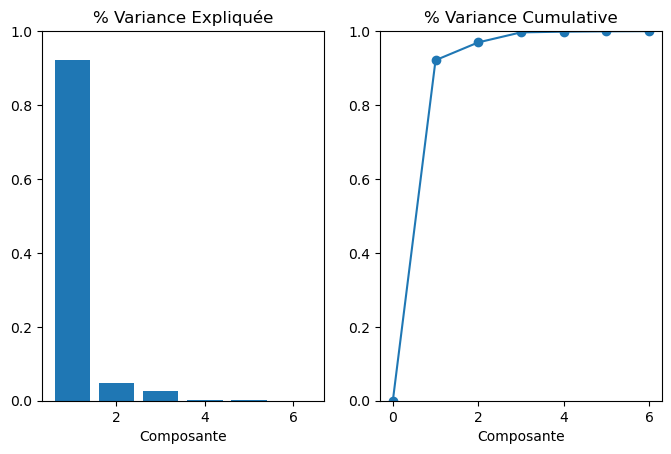

In [231]:
# Call the plot_variance function
plot_variance(pca)

Notre colonne F1 explique à elle seul 77% de l'information contneu dans nos données d'origine.

Nos deux colonnes F1 et F2 explique 87% de l'information contenu dans nos données d'origine.

Nos trois colonnes F1, F2 et F3 explique 96% de l'information contenu dans nos données d'origine.

## ACP 3 component

In [232]:
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(data_num)

PCA(n_components=3)

In [233]:
# Obtenir les composantes principales
pcs = pca.components_

# Convertir les composantes principales en un DataFrame
pcs = pd.DataFrame(pcs)

# Définir les noms des colonnes du DataFrame comme les noms des variables originales
features = data_num.columns
pcs.columns = features

# Définir les index du DataFrame comme les noms des composantes principales (F1, F2)
x_list = list(range(1, len(pcs) + 1))
pcs.index = [f"F{i}" for i in x_list]

# Arrondir les valeurs du DataFrame à deux décimales
pcs.round(2)

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
F1,-0.04,-0.03,0.08,-0.01,-1.00,0.02
F2,0.19,0.96,0.03,-0.19,-0.04,-0.07
F3,0.01,-0.01,0.99,0.07,0.08,0.04


In [234]:
def plot_all_pca_correlation_circles(pca, features):
    n_components = pca.n_components_
    fig, axs = plt.subplots(n_components-1, n_components-1, figsize=(15, 15))

    for i in range(n_components):
        for j in range(i+1, n_components):
            ax = axs[i, j-1]  # j-1 car il n'y a pas de subplot pour i=j
            for k in range(0, pca.components_.shape[1]):
                ax.arrow(0, 0, pca.components_[i, k], pca.components_[j, k], head_width=0.07, head_length=0.07, width=0.02)
                ax.text(pca.components_[i, k] + 0.05, pca.components_[j, k] + 0.05, features[k])
            ax.plot([-1, 1], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-1, 1], color='grey', ls='--')
            ax.set_xlabel('F{} ({}%)'.format(i+1, round(100*pca.explained_variance_ratio_[i],1)))
            ax.set_ylabel('F{} ({}%)'.format(j+1, round(100*pca.explained_variance_ratio_[j],1)))
            ax.set_title("Cercle des corrélations (F{} et F{})".format(i+1, j+1))
            an = np.linspace(0, 2 * np.pi, 100)
            ax.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
            ax.axis('equal')

    plt.tight_layout()
    plt.show(block=False)

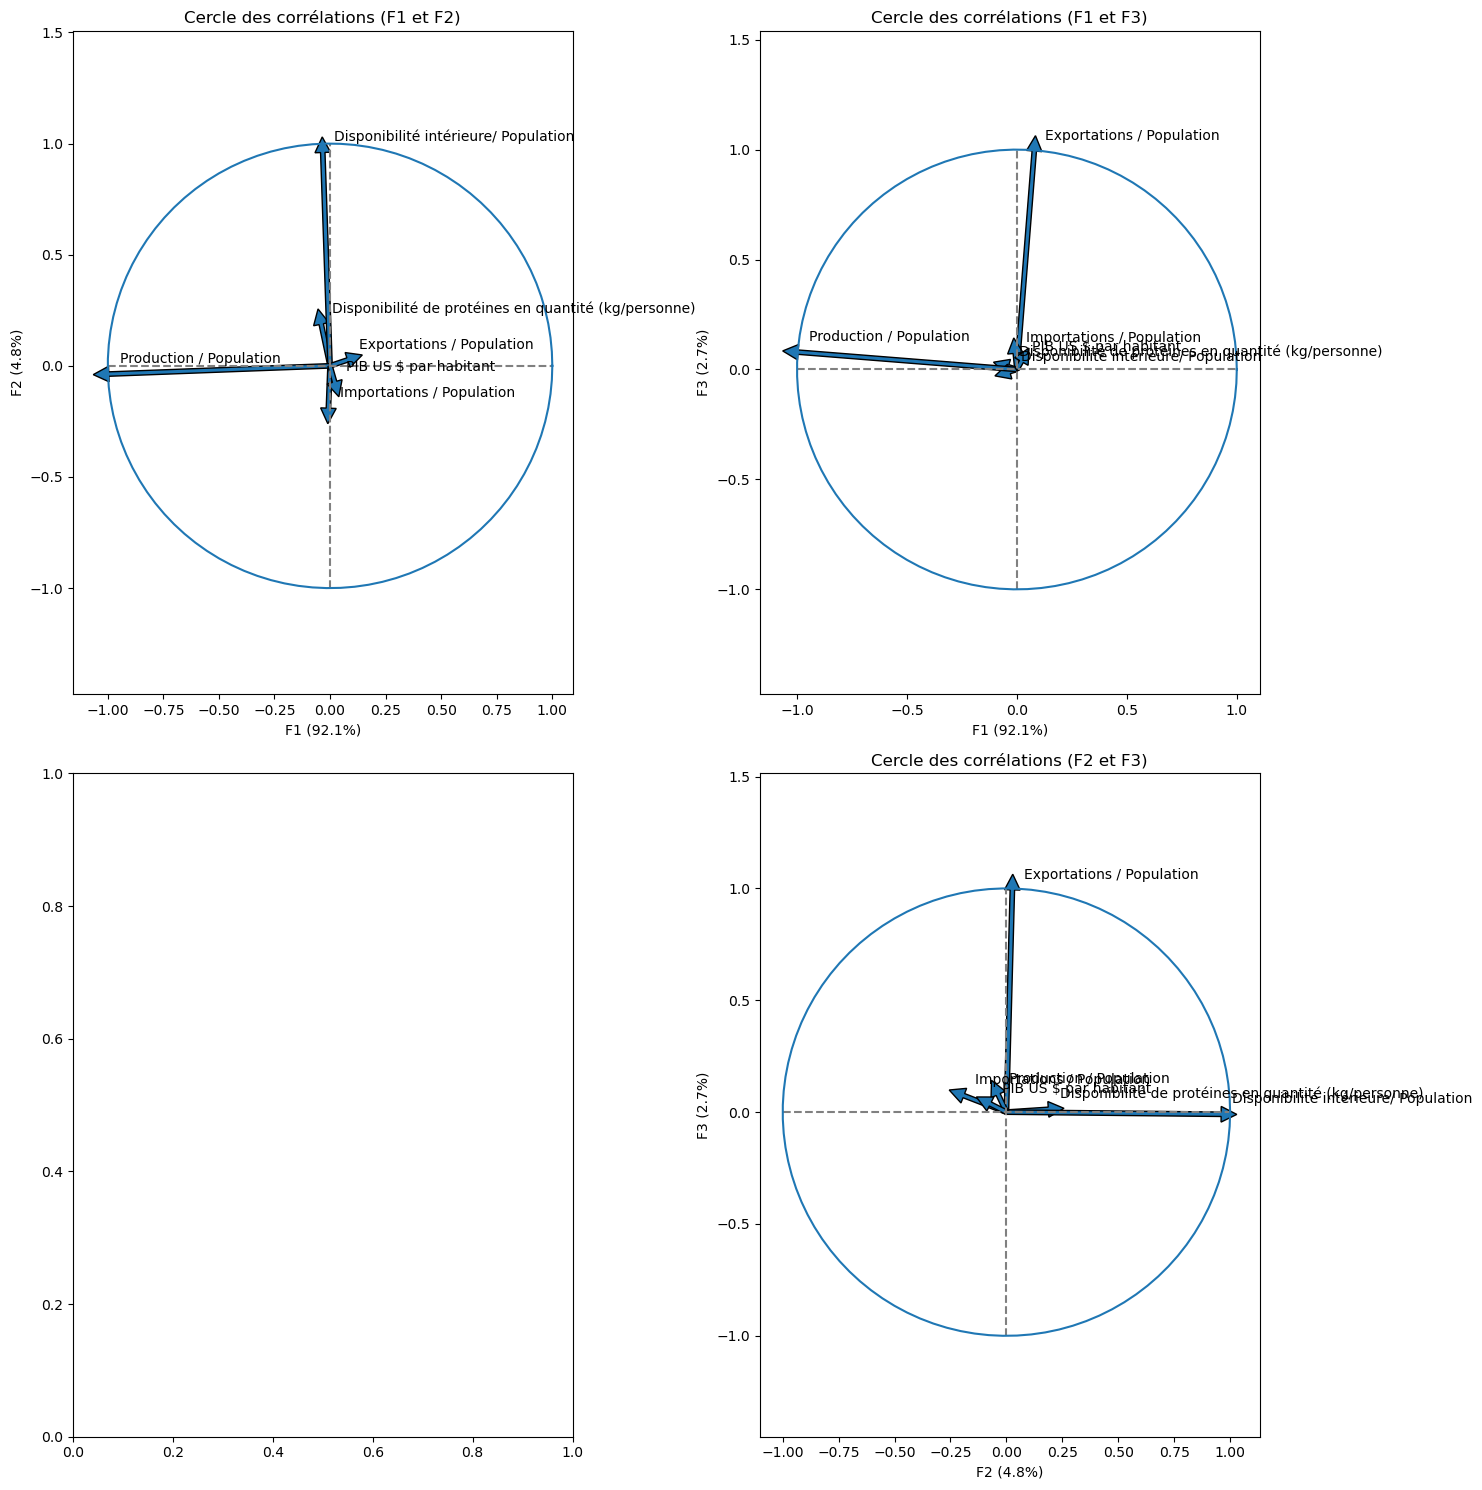

In [235]:
# Utilisation de la fonction
plot_all_pca_correlation_circles(pca, features)

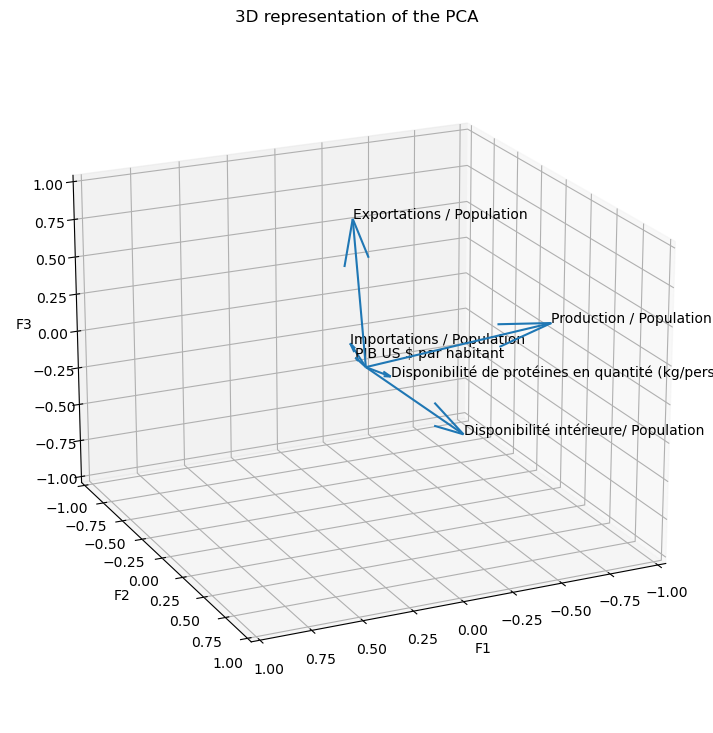

In [236]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

for i in range(pca.components_.shape[1]):
    ax.quiver(0, 0, 0,
              pca.components_[0, i], pca.components_[1, i], pca.components_[2, i])

    ax.text(pca.components_[0, i], pca.components_[1, i], pca.components_[2, i], features[i])

ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set_zlabel('F3')
ax.set_title("3D representation of the PCA")

# Définir les limites des axes
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

ax.view_init(elev=20, azim=65)
plt.show()

In [237]:
import plotly.graph_objects as go

scaling_factor = 1.5  # Adjust the scaling factor as desired

fig = go.Figure()

for i in range(pca.components_.shape[1]):
    # Add a line for the vector
    fig.add_trace(go.Scatter3d(
        x=[0, pca.components_[0, i] * scaling_factor],
        y=[0, pca.components_[1, i] * scaling_factor],
        z=[0, pca.components_[2, i] * scaling_factor],
        mode='lines',
        name=features[i]
    ))

    # Add a cone for the arrowhead
    fig.add_trace(go.Cone(
        x=[pca.components_[0, i] * scaling_factor],
        y=[pca.components_[1, i] * scaling_factor],
        z=[pca.components_[2, i] * scaling_factor],
        u=[pca.components_[0, i] * scaling_factor],
        v=[pca.components_[1, i] * scaling_factor],
        w=[pca.components_[2, i] * scaling_factor],
        sizemode="absolute",
        sizeref=0.2,
        anchor="cm"
    ))

fig.update_layout(
    title="3D representation of the PCA",
    scene=dict(
        xaxis_title='F1',
        yaxis_title='F2',
        zaxis_title='F3',
        aspectratio=dict(x=1, y=1, z=1),
        camera=dict(eye=dict(x=1.2, y=1.2, z=0.6))
    ),
    legend=dict(
        yanchor="top",
        y=0.1,
        xanchor="left",
        x=0.001
    )
)

fig.show()

In [238]:
import plotly.graph_objects as go

principal_components_pivot = pca.fit_transform(data_num)

fig = go.Figure(data=[go.Scatter3d(
    x=principal_components_pivot[:, 0],
    y=principal_components_pivot[:, 1],
    z=principal_components_pivot[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8
    )
)])

fig.update_layout(
    title='ACP - Vue en 3D',
    scene = dict(
        xaxis_title='Composante principale 1',
        yaxis_title='Composante principale 2',
        zaxis_title='Composante principale 3'
    )
)

fig.show()

In [239]:
X_proj = pca.transform(data_num)
df = pd.DataFrame(X_proj, columns = ["F1", "F2","F3"])
df_test = df.copy()
df.head()

,F1,F2,F3
0,-31.420470,10.530113,0.140981
1,25.828790,2.673064,-3.970393
2,-23.277116,-5.149151,-0.081448
3,-19.450838,7.516798,-0.915190
4,4.511390,4.817644,4.481646


# PIPE  

## Dendogramme

In [240]:
# # Créer le pipeline pour le dendogramme
# pipe_dendogramme = Pipeline([
#     ('scaler', StandardScaler()),
#     ('agg', AgglomerativeClustering(n_clusters=nb_clusters, linkage='ward'))
# ])


# def create_dendrogram(df, pipe_dendogramme):
#     """Crée et affiche un dendrogramme pour un DataFrame donné, en utilisant un pipeline donné."""
#     Z = linkage(pipe_dendogramme['scaler'].transform(df), method='ward')
#     clusters = fcluster(Z, 3, criterion='maxclust')
#     plt.figure(figsize=(10, 7))
#     dendrogram(Z)
#     plt.show()

In [241]:
# # Ajuster le pipeline
# pipe_dendogramme.fit(df)
# create_dendrogram(df, pipe_dendogramme)

## Kmeans

In [242]:
# # créer le pipeline pour le kmeans
# pipe_kmeans = Pipeline([
#     ('scaler', StandardScaler()),
#     ('kmeans', KMeans(n_clusters=nb_clusters, random_state=0))
# ])

In [243]:
# # ajuster le pipeline]
# pipe_kmeans.fit(df)

# IV.Dendogramme

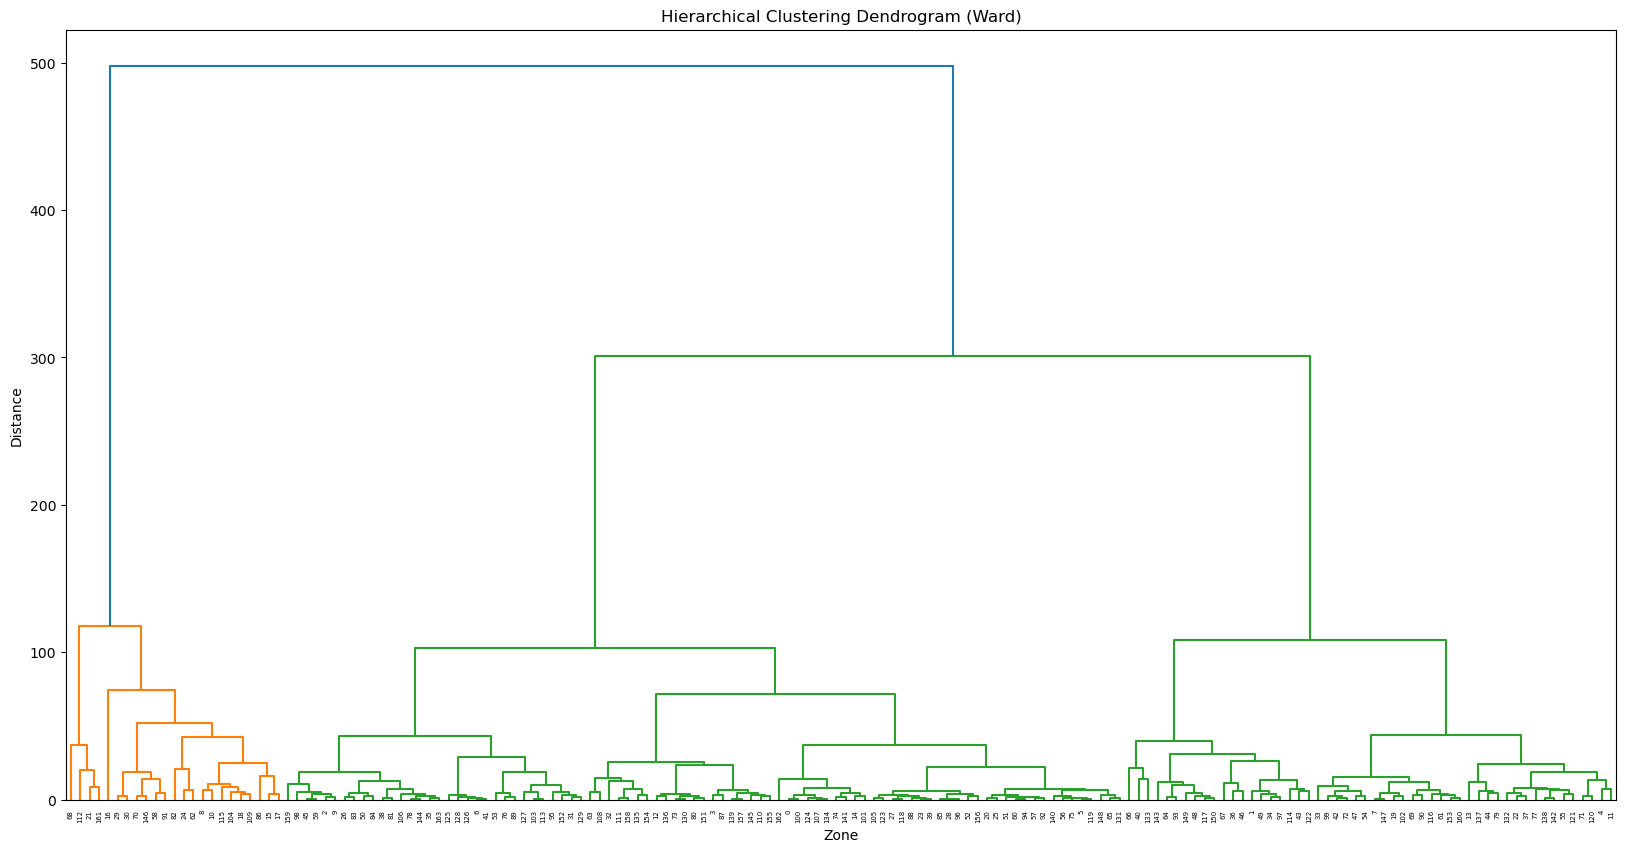

In [244]:
# création du modèle
Z = linkage(df, 'ward')

# Afficher le dendrogramme
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Zone')
plt.ylabel('Distance')
dendrogram(Z,  leaf_rotation=90)
plt.show()

In [245]:
# Coupage du dendrogramme en clusters
clusters = fcluster(Z, nb_clusters, criterion='maxclust')

# VI.Kmeans

In [246]:
# Import the os module
import os
# Set the environment variable 'OMP_NUM_THREADS' to '1'
os.environ['OMP_NUM_THREADS'] = '1'

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

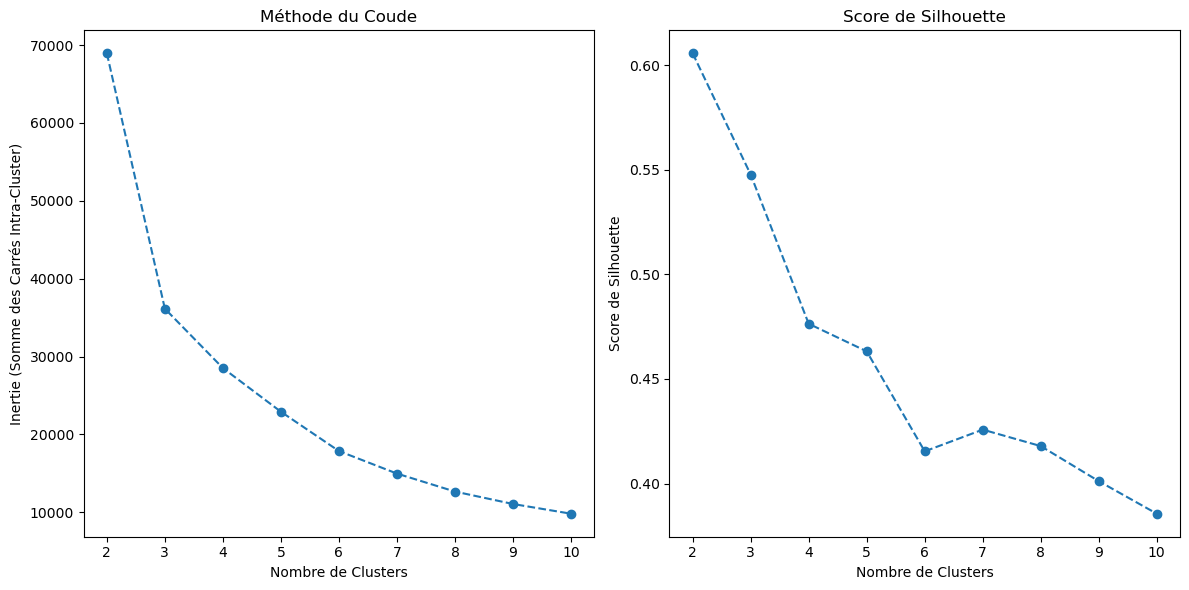

In [247]:
# Définir une plage de nombres de clusters à tester
plage_de_clusters = range(2, 11) 

# Listes pour stocker l'inertie et les scores de silhouette
valeurs_inertie = []
scores_silhouette = []

# Itérer à travers différents nombres de clusters et ajuster K-Means
for n_clusters in plage_de_clusters:
    kmeans_pivot = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters_pivot = kmeans_pivot.fit_predict(df_test)

    # Calculer l'inertie (somme des carrés intra-cluster)
    valeurs_inertie.append(kmeans_pivot.inertia_)

    # Calculer le score de silhouette
    scores_silhouette.append(silhouette_score(df_test, clusters_pivot))

# Tracer la méthode du coude pour déterminer le nombre optimal de clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(plage_de_clusters, valeurs_inertie, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie (Somme des Carrés Intra-Cluster)')
plt.title('Méthode du Coude')

# Tracer le Score de Silhouette pour déterminer le nombre optimal de clusters
plt.subplot(1, 2, 2)
plt.plot(plage_de_clusters, scores_silhouette, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette')

plt.tight_layout()
plt.show()

Méthode du Coude (Elbow Method) :

La Méthode du Coude consiste à trouver le point dans un graphique de l'inertie où la diminution de l'inertie ralentit, formant un coude.
Ce point représente généralement le nombre optimal de clusters dans une analyse de clustering.

Score de Silhouette (Silhouette Score) :

Le Score de Silhouette mesure à quel point les points d'un cluster sont similaires entre eux et différents des autres clusters.
Il varie de -1 à 1, où un score élevé indique une meilleure séparation des clusters.
Le nombre optimal de clusters est généralement celui qui donne le score de silhouette le plus élevé.

In [248]:
# Importer la classe KMeans du module sklearn.cluster
from sklearn.cluster import KMeans

# Créer une instance de la classe KMeans avec 2 clusters
kmeans = KMeans(n_clusters=nb_clusters, n_init=10, random_state=42)

# Entraîner le modèle KMeans sur les données numériques
kmeans.fit(df_test)

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



KMeans(n_clusters=5, n_init=10, random_state=42)

On va cherche les labels de nôre Kmeans afin d'attribuer plus tard un cluster à chaque pays

In [249]:
# Obtenir les labels attribués par KMeans à chaque échantillon
labels = kmeans.labels_
labels[:10]

array([1, 4, 1, 1, 2, 1, 1, 2, 0, 1])

In [250]:
# Ajouter la colonne 'cluster_kmeans' au dataframe 'data' avec les labels attribués par KMeans
df['cluster_kmeans'] = kmeans.labels_

In [251]:
import plotly.express as px

fig = px.scatter_3d(df, x='F1', y='F2', z='F3', color='cluster_kmeans', color_continuous_scale='Viridis')

fig.update_layout(title='Graphique des clusters en 3D')
fig.show()

In [252]:
centroids = kmeans.cluster_centers_
centroids

array([[ 6.02021365e+01, -1.63374780e+00,  4.73456819e-02],
       [-2.56858041e+01,  3.58530250e-02,  6.00243136e-02],
       [ 1.45019902e+00, -4.80328447e-01, -6.46470362e-01],
       [ 1.05130452e+02,  6.19541114e+00,  3.20114755e+00],
       [ 2.46585536e+01,  9.11791141e-01,  1.76375553e-01]])

In [253]:
import plotly.graph_objects as go

fig = px.scatter_3d(df, x='F1', y='F2', z='F3', color='cluster_kmeans', color_continuous_scale='Viridis')

# Ajouter les centroïdes au graphique
fig.add_trace(go.Scatter3d(x=centroids[:, 0], y=centroids[:, 1], z=centroids[:, 2], 
                           mode='markers',
                           marker=dict(size=10, color='red'), 
                           name='centroids'))

fig.update_layout(title='Graphique des clusters en 3D')
fig.show()

# Reconstruction de notre df apres le clustering

Comparaison de nos deux clusterings

In [254]:
# ajout de la colonne 'cluster_dd' au dataframe 'data' avec les labels attribués par le dendogramme
df['cluster_dd'] = clusters
# Ajouter la colonne 'cluster_kmeans' au dataframe 'data' avec les labels attribués par KMeans
df['cluster_kmeans'] = kmeans.labels_

In [255]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Créer une figure avec 2 subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('K-Means Clustering', 'Clustering basé sur le Dendrogramme'), specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# Ajouter le scatter plot pour le clustering K-Means au premier subplot
fig.add_trace(
    go.Scatter3d(x=df['F1'], y=df['F2'], z=df['F3'], mode='markers', marker=dict(color=df['cluster_kmeans'], size=5, colorscale='Viridis', opacity=0.8)),
    row=1, col=1
)

# Ajouter le scatter plot pour le clustering basé sur le dendrogramme au deuxième subplot
fig.add_trace(
    go.Scatter3d(x=df['F1'], y=df['F2'], z=df['F3'], mode='markers', marker=dict(color=df['cluster_dd'], size=5, colorscale='Viridis', opacity=0.8)),
    row=1, col=2
)

# Mettre à jour les layouts pour ajouter les labels d'axes
fig.update_layout(height=600, width=800)
fig.update_xaxes(title_text="Feature1", row=1, col=1)
fig.update_yaxes(title_text="Feature2", row=1, col=1)
fig.update_xaxes(title_text="Feature1", row=1, col=2)
fig.update_yaxes(title_text="Feature2", row=1, col=2)

fig.show()

Reconstruction de nos données d'origine en y ajoutant nos clusters

In [256]:
# Reconstruire les données d'origine
data_reconstructed = pca.inverse_transform(df_test)

# Conversion de l'array en DataFrame
data_reconstructed = pd.DataFrame(data_reconstructed)
column_names = data_num.columns
data_reconstructed.columns = column_names
data_reconstructed.head()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,-11.605851,-4.894042,1.009826,-0.719551,-1.482492,7.279671
1,-15.394168,-14.267968,1.234841,0.056780,-58.497607,8.865833
2,-14.870766,-20.208166,1.015058,2.190513,-9.025911,8.563915
3,-12.657330,-8.167628,0.825201,-0.310711,-13.368013,7.702590
4,-14.044819,-11.593282,8.005662,0.425967,-36.693201,8.581941


In [257]:
# on va rapprocher nos clusters avec le dataframe initial
data_reconstructed['cluster_kmeans'] = df['cluster_kmeans']  
data_reconstructed['cluster_dd'] = df['cluster_dd']
data_reconstructed['Pays'] = pays
# Déplace les colonnes en premier 
data_reconstructed = data_reconstructed.set_index(['Pays', 'cluster_kmeans', 'cluster_dd']).reset_index()
data_reconstructed.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,Afghanistan,1,3,-11.605851,-4.894042,1.009826,-0.719551,-1.482492,7.279671
1,Afrique du Sud,4,4,-15.394168,-14.267968,1.234841,0.056780,-58.497607,8.865833
2,Albanie,1,3,-14.870766,-20.208166,1.015058,2.190513,-9.025911,8.563915
3,Algérie,1,3,-12.657330,-8.167628,0.825201,-0.310711,-13.368013,7.702590
4,Allemagne,2,5,-14.044819,-11.593282,8.005662,0.425967,-36.693201,8.581941


In [258]:
# Calculate the absolute differences between the original dataframe and the reconstructed dataframe
differences = abs(data_num - data_reconstructed.drop(['cluster_kmeans', 'cluster_dd', 'Pays'], axis=1))

# Display the differences
print(differences.mean().sort_values(ascending=False))

Importations / Population                               0.969437
Disponibilité de protéines en quantité (kg/personne)    0.951542
PIB US $ par habitant                                   0.848960
Disponibilité intérieure/ Population                    0.338389
Exportations / Population                               0.076492
Production / Population                                 0.038839
dtype: float64


In [259]:
explained_variance = pca.explained_variance_ratio_.sum()
explained_variance

0.9966134143629202

In [260]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(data_num, data_reconstructed.drop(['cluster_kmeans', 'cluster_dd', 'Pays'], axis=1))
mse

0.7084243714111021

In [261]:
# Modification du type des colonnes 'cluster_kmeans' et 'cluster_dd' en 'str'
data_reconstructed['cluster_kmeans'] = data_reconstructed['cluster_kmeans'].astype(str)
data_reconstructed['cluster_dd'] = data_reconstructed['cluster_dd'].astype(str)
data_recontructed_num = data_reconstructed.select_dtypes(include=[np.number])

# Evaluation des clusters


## Score de silhouette

### Kmeans

Score de silhouette moyen : 0.4632133904923312


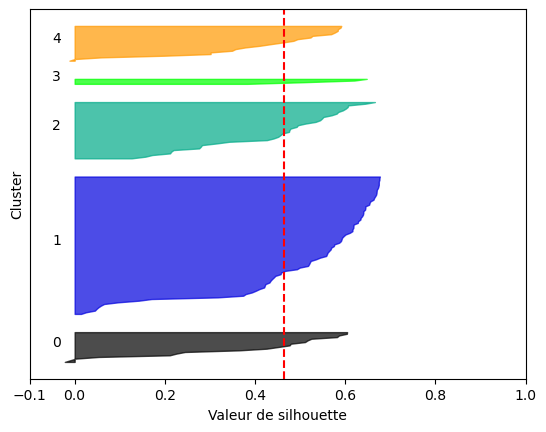

In [262]:
# Calculer le score de silhouette moyen
silhouette_avg = silhouette_score(df_test, labels)
print(f"Score de silhouette moyen : {silhouette_avg}")

# Calculer les scores de silhouette individuels pour chaque échantillon
sample_silhouette_values = silhouette_samples(df_test, labels)

# Créer un silhouette plot
fig, ax = plt.subplots()
y_lower = 10

for i in range(len(np.unique(labels))):
    # Aggrège les scores de silhouette pour les échantillons appartenant à un cluster particulier
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / len(np.unique(labels)))
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Étiqueter chaque cluster avec son numéro au milieu
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calculer la nouvelle position y_lower pour le prochain plot
    y_lower = y_upper + 10

ax.set_xlabel("Valeur de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()


### Dendogramme

Score de silhouette moyen : 0.47260221521419243


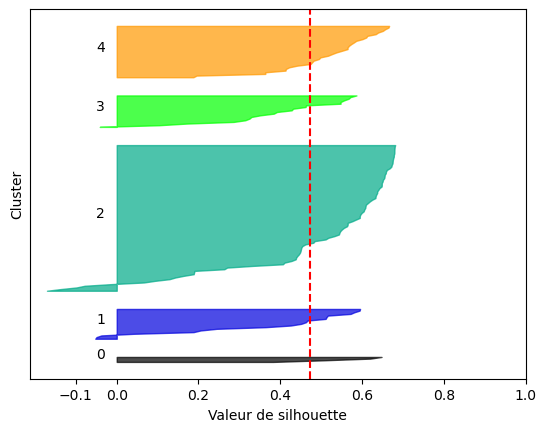

In [263]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Réorganiser les numéros de cluster pour qu'ils soient continus de 0 à 1
clusters = clusters - 1

# Calculer le score de silhouette moyen
silhouette_avg = silhouette_score(df_test, clusters)
print(f"Score de silhouette moyen : {silhouette_avg}")

# Calculer les scores de silhouette individuels pour chaque échantillon
sample_silhouette_values = silhouette_samples(df_test, clusters)

# Créer un silhouette plot
fig, ax = plt.subplots()
y_lower = 10

for i in range(len(np.unique(clusters))):
    # Aggrège les scores de silhouette pour les échantillons appartenant à un cluster particulier
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / len(np.unique(clusters)))
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Étiqueter chaque cluster avec son numéro au milieu
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calculer la nouvelle position y_lower pour le prochain plot
    y_lower = y_upper + 10

ax.set_xlabel("Valeur de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

## ARI

In [264]:
# Importer la fonction adjusted_rand_score du module sklearn.metrics
from sklearn.metrics import adjusted_rand_score

# Obtenir les labels attribués par KMeans et le dendrogramme
labels_kmeans = kmeans.labels_
labels_dendrogramme = clusters

# Calculer l'Indice de Rand Ajusté (ARI) en comparant les deux ensembles de labels
ari = adjusted_rand_score(labels_kmeans, labels_dendrogramme)

# Afficher le résultat
print("Indice de Rand Ajusté :", ari)


Indice de Rand Ajusté : 0.8894010744146867


# Etude des clusters

### Fonctions pour l'étude des clusters

In [265]:
from math import pi

def get_cluster_data(data, cluster_column, cluster_value):
    """Renvoie un sous-ensemble de données pour le cluster spécifié."""
    return data[data[cluster_column] == cluster_value]

def radar_plot(*cluster_data_list):
    """Crée un radar plot pour les variables numériques de plusieurs clusters."""
    for cluster_data in cluster_data_list:
        numeric_columns = cluster_data.select_dtypes(include='number').columns
        stats = cluster_data[numeric_columns].mean().tolist()
        stats += stats[:1]  # repeat the first value to close the circular graph
        angles = [n / float(len(numeric_columns)) * 2 * pi for n in range(len(numeric_columns))]
        angles += angles[:1]
        plt.polar(angles, stats)
        plt.fill(angles, stats, alpha=0.1)
    plt.xticks(angles[:-1], numeric_columns)
    plt.show()
    
def plot_boxplot(data):
    """Crée un boxplot pour toutes les colonnes numériques côte à côte."""
    numeric_columns = data.select_dtypes(include='number').columns
    sns.boxplot(data=data[numeric_columns])
    plt.xticks(rotation=90)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
    plt.show()
    
def radar_plot_subplot(cluster_data_list, ax):
    """Crée un radar plot pour les variables numériques de plusieurs clusters."""
    for cluster_data in cluster_data_list:
        numeric_columns = cluster_data.select_dtypes(include='number').columns
        stats = cluster_data[numeric_columns].mean().tolist()
        stats += stats[:1]  # repeat the first value to close the circular graph
        angles = [n / float(len(numeric_columns)) * 2 * pi for n in range(len(numeric_columns))]
        angles += angles[:1]
        ax.plot(angles, stats)  # Utilisez plot au lieu de polar
        ax.fill(angles, stats, alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(numeric_columns)

def plot_boxplot_subplot(data, ax):
    """Crée un boxplot pour toutes les colonnes numériques côte à côte."""
    numeric_columns = data.select_dtypes(include='number').columns
    sns.boxplot(data=data[numeric_columns], ax=ax)
    ax.set_xticklabels(numeric_columns, rotation=90)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité

def plot_subplots(cluster_data_list, data):
    """Crée un subplot avec un radar plot et un boxplot."""
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, polar=True)
    ax2 = fig.add_subplot(122)
    radar_plot_subplot(cluster_data_list, ax1)
    plot_boxplot_subplot(data, ax2)
    plt.show()
    
def descriptive_statistics(cluster_data):
    """Affiche les statistiques descriptives pour les colonnes numériques du cluster."""
    numeric_columns = cluster_data.select_dtypes(include='number')
    print(numeric_columns.describe())
    
def analyze_cluster(data, cluster_column, cluster_value):
    """Analyse un cluster spécifié en appelant toutes les fonctions."""
    cluster_data = get_cluster_data(data, cluster_column, cluster_value)
    print('Boxplot et radarplot pour le cluster', cluster_value)
    plot_subplots([cluster_data], data)
    # print("Boxplot des colonnes numériques :")
    # plot_boxplot(cluster_data)
    # print("Radar plot des colonnes numériques :")
    # radar_plot(cluster_data)
    # print("Statistiques descriptives des colonnes numériques :")
    # descriptive_statistics(cluster_data)    

Création des datframes à partir des clusters

In [266]:
# Créez des DataFrames pour chaque cluster Kmeans
from scipy import cluster

cluster_1_kmeans = get_cluster_data(data_reconstructed, 'cluster_kmeans', '1')
cluster_2_kmeans = get_cluster_data(data_reconstructed, 'cluster_kmeans', '2')
cluster_3_kmeans = get_cluster_data(data_reconstructed, 'cluster_kmeans', '0')
cluster_4_kmeans = get_cluster_data(data_reconstructed, 'cluster_kmeans', '3')
cluster_5_kmeans = get_cluster_data(data_reconstructed, 'cluster_kmeans', '4')

# Créez des DataFrames pour chaque cluster dendogramme
cluster_1_dd = get_cluster_data(data_reconstructed, 'cluster_dd', '1')
cluster_2_dd = get_cluster_data(data_reconstructed, 'cluster_dd', '2')
cluster_3_dd = get_cluster_data(data_reconstructed, 'cluster_dd', '3')
cluster_4_dd = get_cluster_data(data_reconstructed, 'cluster_dd', '4')
cluster_5_dd = get_cluster_data(data_reconstructed, 'cluster_dd', '5')

### Etude global des clusters

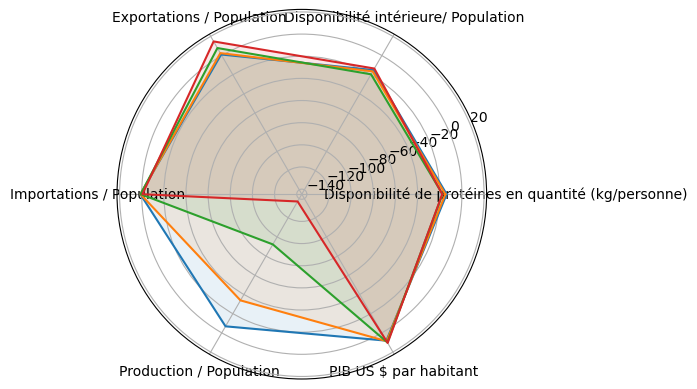

In [267]:
radar_plot(cluster_1_kmeans, cluster_2_kmeans, cluster_3_kmeans,cluster_4_kmeans)

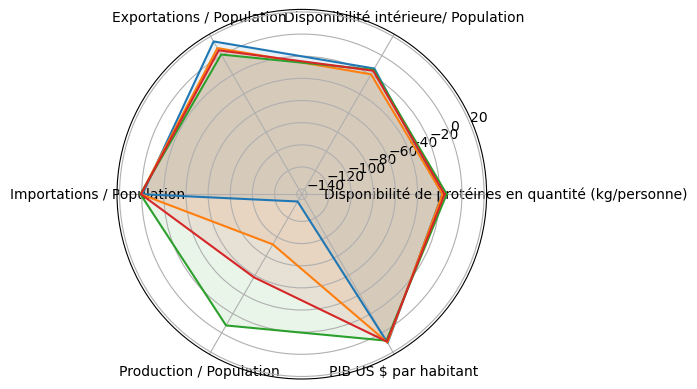

In [268]:
radar_plot(cluster_1_dd, cluster_2_dd, cluster_3_dd,cluster_4_dd)

## Kmeans

### CLuster Kmeans 1

Boxplot et radarplot pour le cluster 1


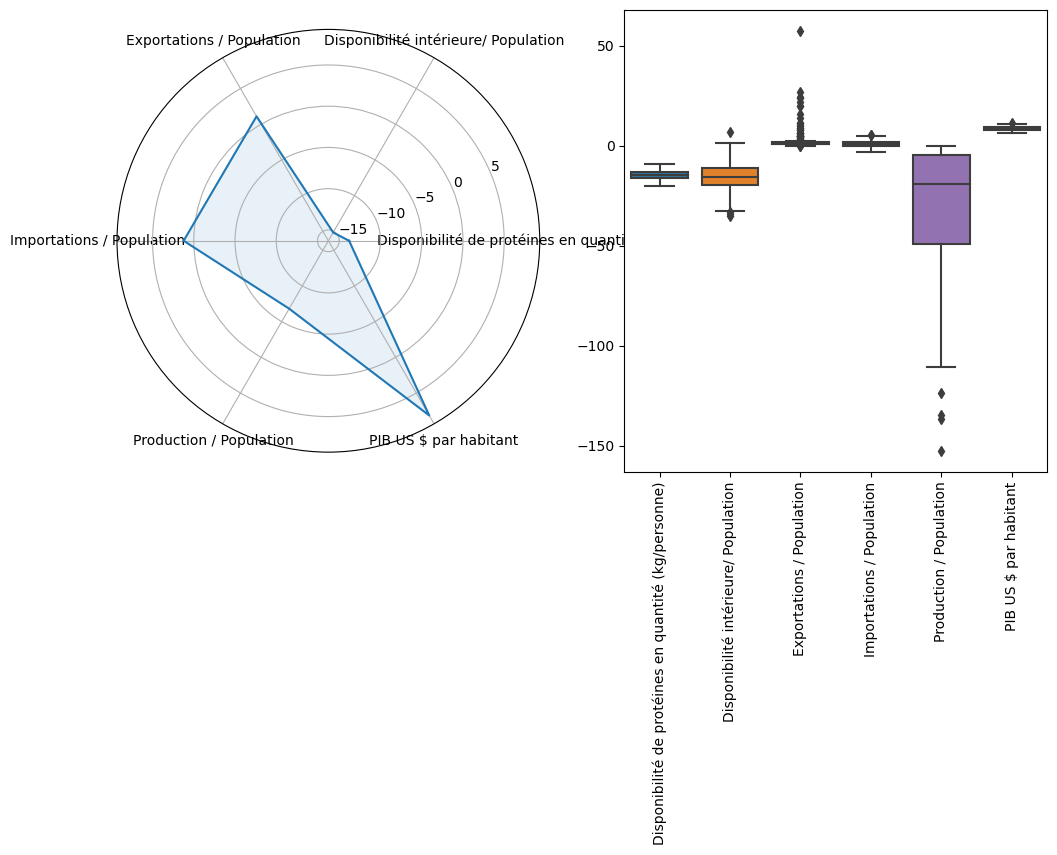

In [269]:
analyze_cluster(data_reconstructed, 'cluster_kmeans', '1')

In [270]:
cluster_1_kmeans.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,-13.801493,-15.153852,1.103228,1.231107,-6.808936,8.147500
std,1.845957,9.222790,1.147629,1.840213,5.578807,0.727115
min,-17.594173,-35.293009,-0.229376,-3.076290,-19.436007,6.347121
25%,-14.732379,-19.860055,0.910876,-0.173175,-10.032367,7.605048
50%,-13.532474,-13.931338,0.975360,0.925034,-4.624758,8.030612
75%,-12.420632,-8.166025,1.020670,2.329455,-2.178563,8.547963
max,-9.222768,7.017475,10.021975,5.332597,-0.165374,9.631076


In [271]:
cluster_1_kmeans.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,Afghanistan,1,3,-11.605851,-4.894042,1.009826,-0.719551,-1.482492,7.279671
2,Albanie,1,3,-14.870766,-20.208166,1.015058,2.190513,-9.025911,8.563915
3,Algérie,1,3,-12.657330,-8.167628,0.825201,-0.310711,-13.368013,7.702590
5,Angola,1,3,-13.039070,-11.962979,1.111696,0.672147,-2.839159,7.844025
6,Antigua-et-Barbuda,1,3,-17.212337,-33.349519,0.958787,4.945802,-2.027731,9.460117


Ce cluster est les pays exportateur de poulet, pas intéressant pour notre étude

### Cluster Kmeans 2

Boxplot et radarplot pour le cluster 2


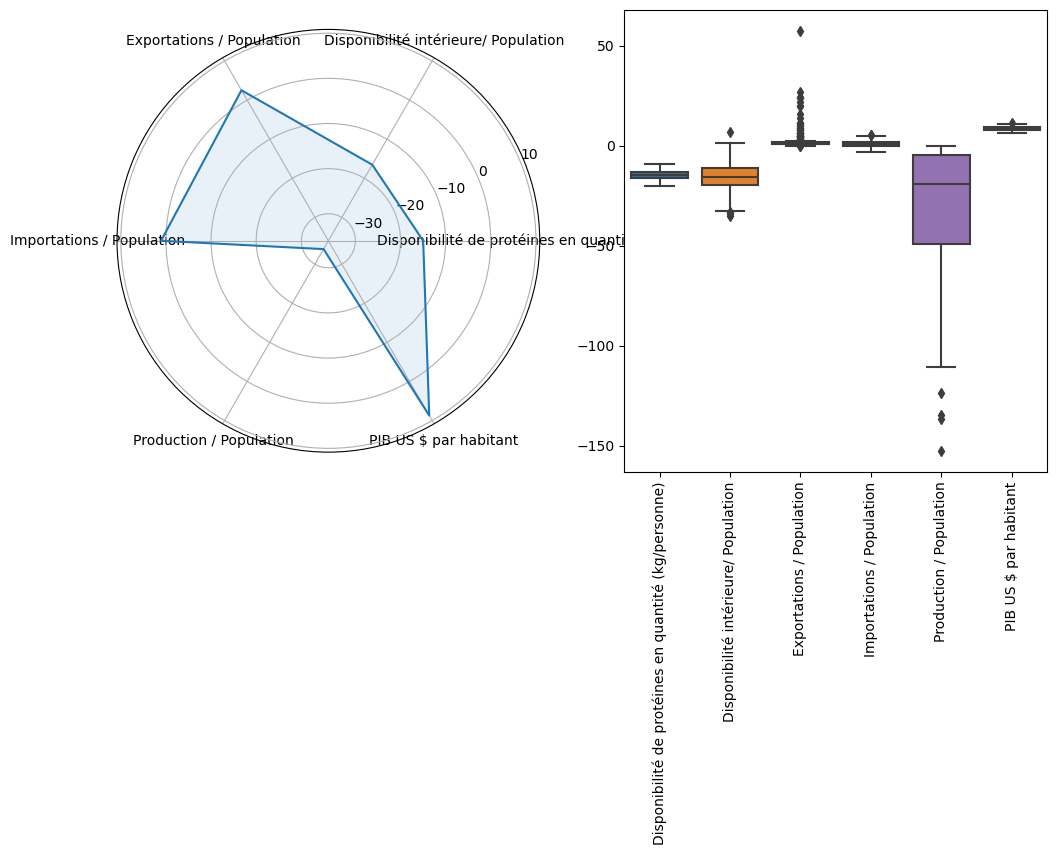

In [272]:
analyze_cluster(data_reconstructed, 'cluster_kmeans', '2')

In [273]:
cluster_2_kmeans.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,-14.980302,-16.529627,2.529163,1.079638,-33.854614,8.713995
std,1.068117,5.208637,3.092502,1.127564,6.872778,0.472222
min,-17.325675,-28.801086,-0.169242,-2.020731,-44.803364,7.324777
25%,-15.569927,-18.608838,0.485439,0.451023,-40.226432,8.530238
50%,-15.018171,-17.174454,0.974613,0.993756,-33.819140,8.728701
75%,-14.537214,-14.183458,3.349915,1.619199,-28.478793,8.927629
max,-11.663714,-0.926584,10.292982,3.472519,-21.141294,9.677640


In [274]:
cluster_2_kmeans.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
4,Allemagne,2,5,-14.044819,-11.593282,8.005662,0.425967,-36.693201,8.581941
7,Arabie saoudite,2,5,-15.097012,-16.408429,0.480265,0.844187,-37.269439,8.680695
11,Autriche,2,5,-15.114271,-17.634764,8.954371,1.759098,-33.599607,9.031804
12,Azerbaïdjan,2,3,-14.341815,-15.402269,0.993327,0.993756,-21.141294,8.379023
13,Bahamas,2,5,-17.325675,-28.801086,1.077990,3.472519,-31.489211,9.562247


### Cluster Kmeans 3

Boxplot et radarplot pour le cluster 0


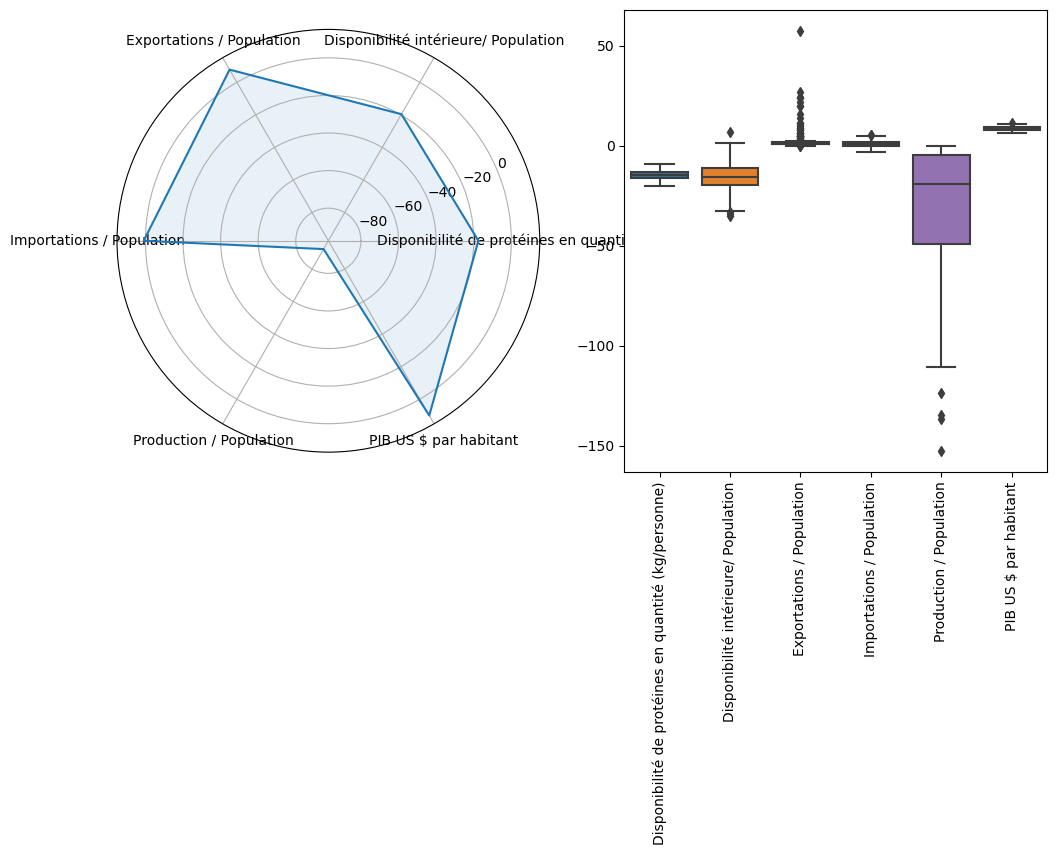

In [275]:
analyze_cluster(data_reconstructed, 'cluster_kmeans', '0')

In [276]:
cluster_3_kmeans.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,-17.511886,-19.563932,7.824230,0.922205,-92.234477,10.023607
std,1.054314,4.663287,14.030771,1.198618,10.901298,0.516507
min,-19.879971,-29.033587,-0.116575,-0.910553,-110.800658,9.266008
25%,-18.005791,-23.480524,0.888115,-0.023461,-99.847636,9.663382
50%,-17.372413,-17.565858,1.508191,0.950184,-94.876163,9.922015
75%,-16.923320,-15.969059,5.551727,1.659343,-81.982730,10.356157
max,-15.600995,-13.189775,57.414014,3.672041,-75.929423,11.313980


In [277]:
cluster_3_kmeans.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
8,Argentine,0,2,-16.667630,-14.001159,4.625327,-0.534236,-98.402826,9.573706
10,Australie,0,2,-17.377324,-16.599737,1.744777,-0.313679,-103.259969,9.739297
15,Barbade,0,2,-19.879971,-29.033587,0.987382,2.084659,-104.794656,10.684512
16,Belgique,0,2,-15.600995,-14.698759,57.414014,3.672041,-81.063035,11.313980
17,Belize,0,2,-19.328246,-25.910330,0.873300,1.418929,-106.554751,10.468273


### Cluster Kmeans 4

Boxplot et radarplot pour le cluster 3


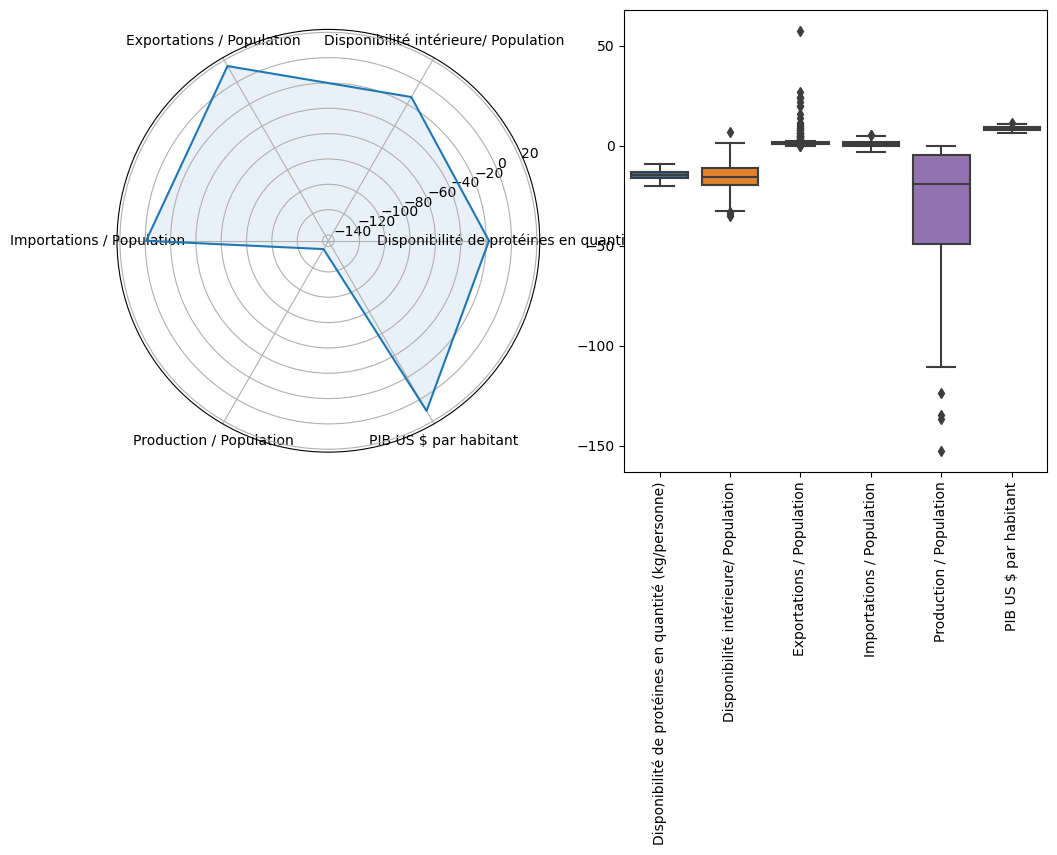

In [278]:
analyze_cluster(data_reconstructed, 'cluster_kmeans', '3')

In [279]:
cluster_4_kmeans.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,-17.782060,-13.547733,14.710691,-0.663930,-136.993466,10.494638
std,1.469103,5.498664,11.455473,0.943075,11.822101,0.358699
min,-19.970360,-21.139833,0.409727,-1.625440,-152.551710,10.045768
25%,-17.959722,-15.821494,8.673994,-1.250213,-140.674429,10.284874
50%,-17.138648,-11.865762,15.740064,-0.793534,-135.782302,10.573196
75%,-16.960986,-9.592001,21.776761,-0.207252,-132.101338,10.782961
max,-16.880585,-9.319577,26.952910,0.556788,-123.857548,10.786394


In [280]:
cluster_4_kmeans.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
21,Brésil,3,1,-16.880585,-9.319577,20.051378,-1.125137,-136.715336,10.364576
68,Israël,3,1,-19.970360,-21.139833,0.409727,-0.461931,-152.551710,10.781817
112,Pologne,3,1,-17.289510,-14.048714,26.952910,0.556788,-123.857548,10.786394
161,États-Unis d'Amérique,3,1,-16.987786,-9.682809,11.428750,-1.625440,-134.849268,10.045768


### Cluster Kmeans 5

Boxplot et radarplot pour le cluster 5


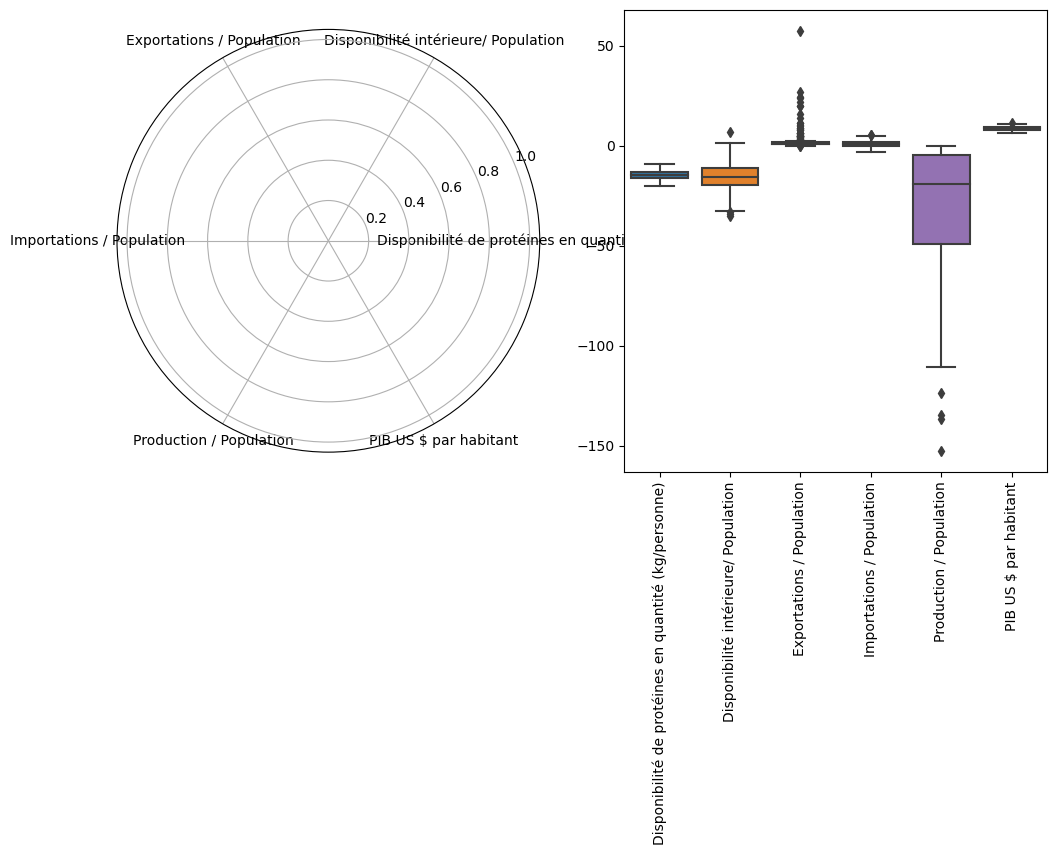

In [281]:
analyze_cluster(data_reconstructed, 'cluster_kmeans', '5')

In [282]:
cluster_5_kmeans.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,-15.627103,-15.959889,5.215056,0.705984,-56.941029,9.118531
std,1.048410,5.083925,6.602794,1.190388,7.085013,0.515581
min,-18.171236,-28.157549,0.086177,-0.783852,-70.172980,8.469474
25%,-16.298341,-19.053372,0.786946,-0.294167,-62.030748,8.771582
50%,-15.397253,-14.301437,2.541702,0.315494,-54.432438,8.924529
75%,-14.835603,-12.347805,6.001674,1.221696,-52.754938,9.424400
max,-13.881460,-8.890269,24.291137,2.866269,-46.326518,10.211693


In [283]:
cluster_5_kmeans.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
1,Afrique du Sud,4,4,-15.394168,-14.267968,1.234841,0.056780,-58.497607,8.865833
34,Colombie,4,4,-15.375306,-13.150699,0.086177,-0.353982,-63.970999,8.820777
36,Costa Rica,4,4,-16.190516,-19.116853,0.629949,1.074522,-53.740528,9.142077
40,Danemark,4,4,-16.389853,-20.367649,24.291137,2.866269,-60.387172,10.211693
43,Espagne,4,4,-15.589780,-14.334906,4.664188,0.185927,-64.991115,9.095697


## Dendogramme

### Cluster Dendogramme 1

Boxplot et radarplot pour le cluster 3


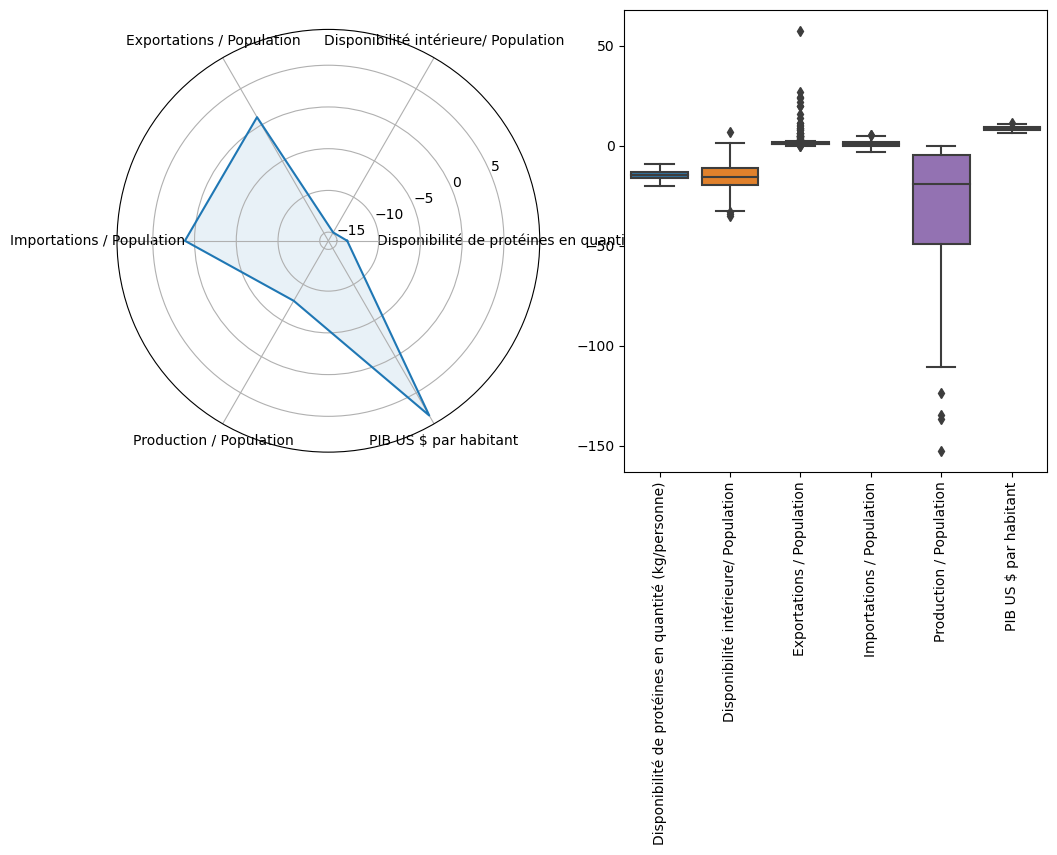

In [284]:
analyze_cluster(data_reconstructed, 'cluster_dd', '3')

In [285]:
cluster_1_dd.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,-17.782060,-13.547733,14.710691,-0.663930,-136.993466,10.494638
std,1.469103,5.498664,11.455473,0.943075,11.822101,0.358699
min,-19.970360,-21.139833,0.409727,-1.625440,-152.551710,10.045768
25%,-17.959722,-15.821494,8.673994,-1.250213,-140.674429,10.284874
50%,-17.138648,-11.865762,15.740064,-0.793534,-135.782302,10.573196
75%,-16.960986,-9.592001,21.776761,-0.207252,-132.101338,10.782961
max,-16.880585,-9.319577,26.952910,0.556788,-123.857548,10.786394


In [286]:
cluster_1_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
21,Brésil,3,1,-16.880585,-9.319577,20.051378,-1.125137,-136.715336,10.364576
68,Israël,3,1,-19.970360,-21.139833,0.409727,-0.461931,-152.551710,10.781817
112,Pologne,3,1,-17.289510,-14.048714,26.952910,0.556788,-123.857548,10.786394
161,États-Unis d'Amérique,3,1,-16.987786,-9.682809,11.428750,-1.625440,-134.849268,10.045768


Pays exportateur pas interessant

### Cluster Dendogramme 2

Boxplot et radarplot pour le cluster 3


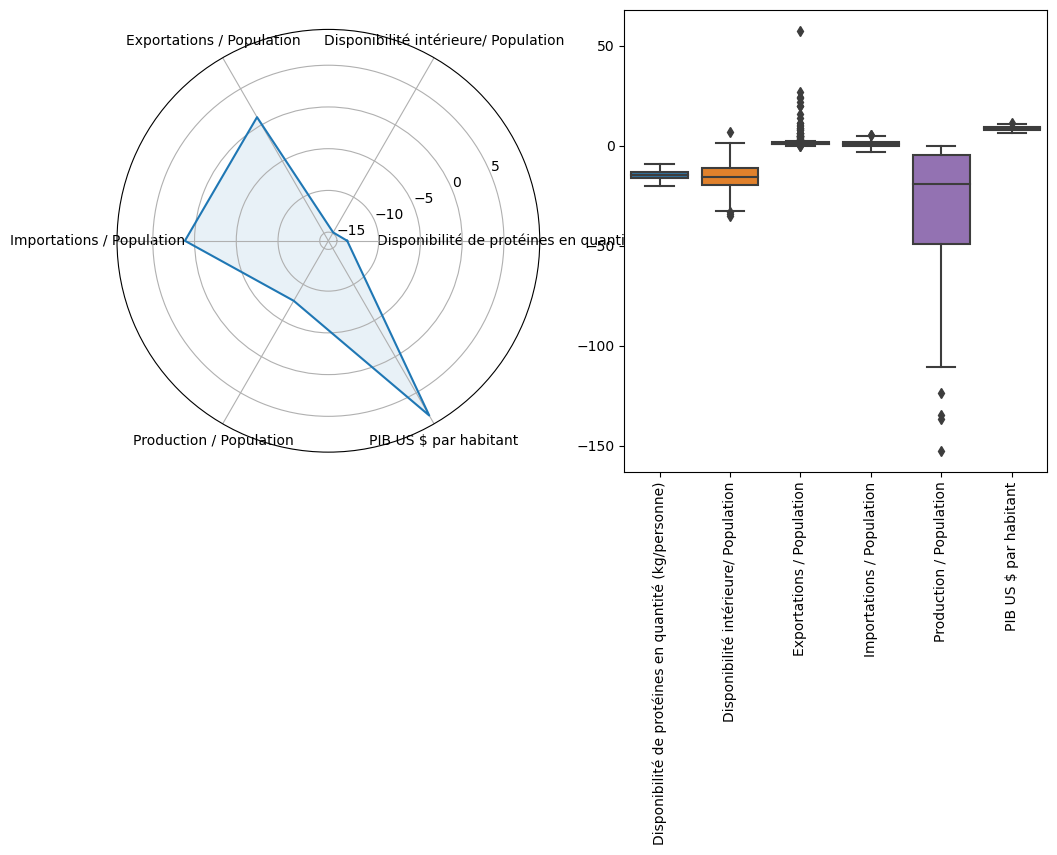

In [287]:
analyze_cluster(data_reconstructed, 'cluster_dd', '3')

In [288]:
cluster_2_dd.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,-17.511886,-19.563932,7.824230,0.922205,-92.234477,10.023607
std,1.054314,4.663287,14.030771,1.198618,10.901298,0.516507
min,-19.879971,-29.033587,-0.116575,-0.910553,-110.800658,9.266008
25%,-18.005791,-23.480524,0.888115,-0.023461,-99.847636,9.663382
50%,-17.372413,-17.565858,1.508191,0.950184,-94.876163,9.922015
75%,-16.923320,-15.969059,5.551727,1.659343,-81.982730,10.356157
max,-15.600995,-13.189775,57.414014,3.672041,-75.929423,11.313980


In [289]:
cluster_2_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
8,Argentine,0,2,-16.667630,-14.001159,4.625327,-0.534236,-98.402826,9.573706
10,Australie,0,2,-17.377324,-16.599737,1.744777,-0.313679,-103.259969,9.739297
15,Barbade,0,2,-19.879971,-29.033587,0.987382,2.084659,-104.794656,10.684512
16,Belgique,0,2,-15.600995,-14.698759,57.414014,3.672041,-81.063035,11.313980
17,Belize,0,2,-19.328246,-25.910330,0.873300,1.418929,-106.554751,10.468273


peu de prod, pas d'exportations , bon cluster

### Cluster Dendogramme 3

Boxplot et radarplot pour le cluster 3


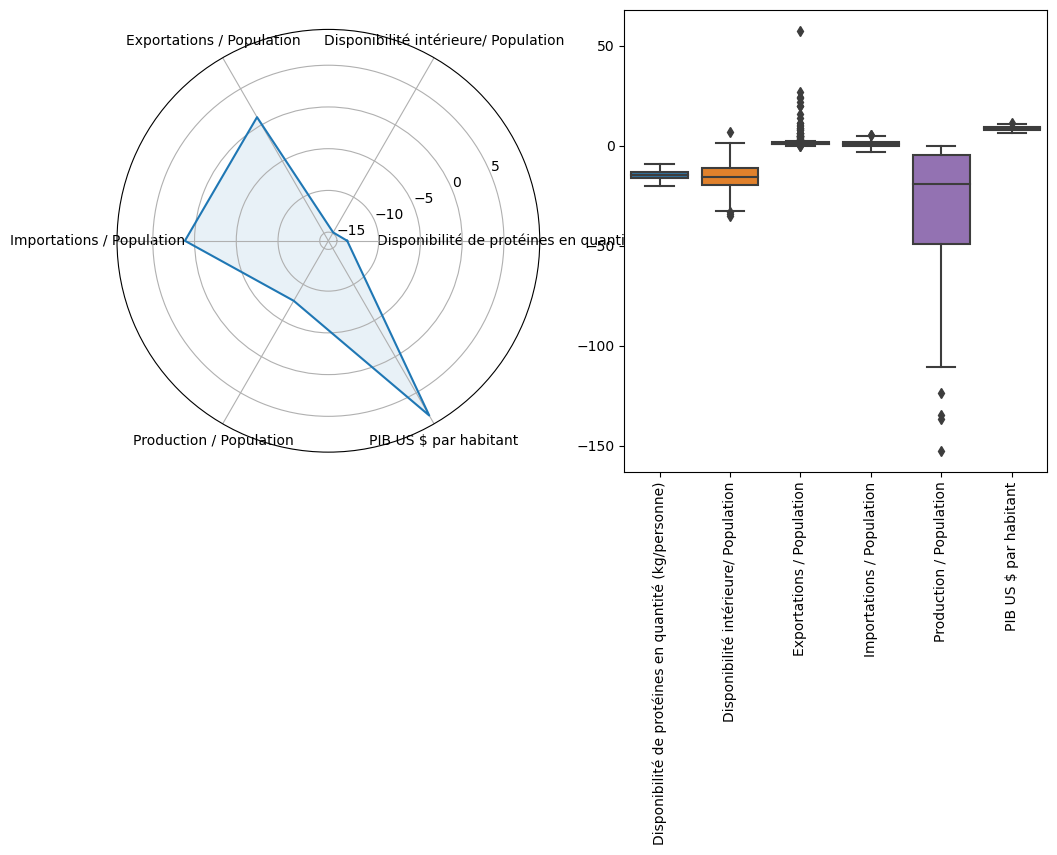

In [290]:
analyze_cluster(data_reconstructed, 'cluster_dd' , '3')

In [291]:
cluster_3_dd.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,-13.779986,-14.881796,1.066007,1.156251,-7.729244,8.139248
std,1.813271,9.131742,1.128248,1.835978,6.626495,0.714141
min,-17.594173,-35.293009,-0.229376,-3.076290,-25.774256,6.347121
25%,-14.729847,-19.690741,0.902216,-0.193647,-10.978718,7.609662
50%,-13.521638,-13.848778,0.973087,0.922443,-5.149570,8.025683
75%,-12.430812,-8.167628,1.015282,2.257582,-2.287767,8.521240
max,-9.222768,7.017475,10.021975,5.332597,-0.165374,9.631076


In [292]:
cluster_3_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,Afghanistan,1,3,-11.605851,-4.894042,1.009826,-0.719551,-1.482492,7.279671
2,Albanie,1,3,-14.870766,-20.208166,1.015058,2.190513,-9.025911,8.563915
3,Algérie,1,3,-12.657330,-8.167628,0.825201,-0.310711,-13.368013,7.702590
5,Angola,1,3,-13.039070,-11.962979,1.111696,0.672147,-2.839159,7.844025
6,Antigua-et-Barbuda,1,3,-17.212337,-33.349519,0.958787,4.945802,-2.027731,9.460117


Trop de prod

# Sélection des pays

In [293]:
cluster_2_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
8,Argentine,0,2,-16.667630,-14.001159,4.625327,-0.534236,-98.402826,9.573706
10,Australie,0,2,-17.377324,-16.599737,1.744777,-0.313679,-103.259969,9.739297
15,Barbade,0,2,-19.879971,-29.033587,0.987382,2.084659,-104.794656,10.684512
16,Belgique,0,2,-15.600995,-14.698759,57.414014,3.672041,-81.063035,11.313980
17,Belize,0,2,-19.328246,-25.910330,0.873300,1.418929,-106.554751,10.468273
